# Problem description

La denoising delle immagini è un problema ben noto nel campo della computer vision, spesso risolto mediante algoritmi statistici. Tuttavia, con l'introduzione delle reti neurali convoluzionali (CNN), sono stati ottenuti risultati molto interessanti con tali architetture. Qui implementerò tre architetture, ordinate dalla più semplice/peggiore alla più complessa/migliore.

# Dataset and basic functions

In [ ]:
# import the necessary packages

import tensorflow as tf
from tensorflow import keras as ks
import random
from cv2 import GaussianBlur
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Activation, Flatten, Dense, Add, ReLU, Concatenate, Reshape, Input, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

#FUNCTION NEEDED TO DOWNLOAD, NORMALIZE AND BLUR THE DATA
def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

#FUNCTION NEEDED TO PLOT TWO IMAGES
def show(x, y, title=None):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(x)
    if title:
        plt.title(title[0])

    plt.subplot(1, 2, 2)
    plt.imshow(y)
    if title:
        plt.title(title[1])

    plt.show()

#FUNCTION TO PLOT METRICS OF THE TRAINING PHASE
def plot_results(hist):
  loss_history = hist.history['loss']
  val_loss_history = hist.history['val_loss']

  mae_history = hist.history['mae']
  val_mae_history = hist.history['val_mae']

  PSNR_history = hist.history['PSNR']
  val_PSNR_history = hist.history['val_PSNR']

  ssim_history = hist.history['ssim']
  val_ssim_history = hist.history['val_ssim']

  fig, ax = plt.subplots(2, 2)


  ax[0, 0].plot(loss_history)
  ax[0, 0].plot(val_loss_history)
  ax[0, 0].grid()
  ax[0, 0].legend(['Loss - mse', 'Val Loss - mse'])
  ax[0, 0].set_title('Mean Squared Error')

  ax[0, 1].plot(mae_history)
  ax[0, 1].plot(val_mae_history)
  ax[0, 1].grid()
  ax[0, 1].legend(['mae', 'Val mae'])
  ax[0, 1].set_title('Mean Absolute Error')

  ax[1, 0].plot(PSNR_history)
  ax[1, 0].plot(val_PSNR_history)
  ax[1, 0].grid()
  ax[1, 0].legend(['PSNR', 'val PSNR'])
  ax[1, 0].set_title('Peak signal-to-noise ratio')

  ax[1, 1].plot(ssim_history)
  ax[1, 1].plot(val_ssim_history)
  ax[1, 1].grid()
  ax[1, 1].legend(['ssim', 'val ssim'])
  ax[1, 1].set_title('Structural similarity')

  fig.text(0.5, 0.09, 'Epochs', ha='center', va='center', size = 'x-large')
  fig.set_size_inches(18.5, 10.5)


#FUNCTION TO PLOT DATASET AND RESULTS
def plot_imgs(x, y, predicted = [], num = 10):
    plt.figure(figsize=(20, 6))
    for i in range(num):
        # display original
        ax = plt.subplot(3, num, i+1)
        imshow(x[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, num, i +1 + num)
        imshow(y[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if len(predicted) > 0:
          # display denoised image
          ax = plt.subplot(3, num, i +1 + num + num)
          imshow(predicted[i])
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
    plt.figtext(0.5,0.95, "NOISY INPUT IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.65, "GROUND TRUTH IMAGES", ha="center", va="top", fontsize=14, color="b")
    if len(predicted) > 0:
      plt.figtext(0.5,0.35, "PREDICTED IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.subplots_adjust(hspace = 0.5 )
    plt.show()


def PSNR(super_resolution, high_resolution):
  """Compute the peak signal-to-noise ratio, measures quality of image."""
  # Max value of pixel is 0
  psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=1)[0]
  return psnr_value

def ssim(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))


#SEARCH FOR TPU
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
  TPU = True
except ValueError:
  strategy = tf.distribute.get_strategy()
  TPU = False

Train: X=(50000, 32, 32, 3), y=(50000, 32, 32, 3)
Test: X=(10000, 32, 32, 3), y=(10000, 32, 32, 3)


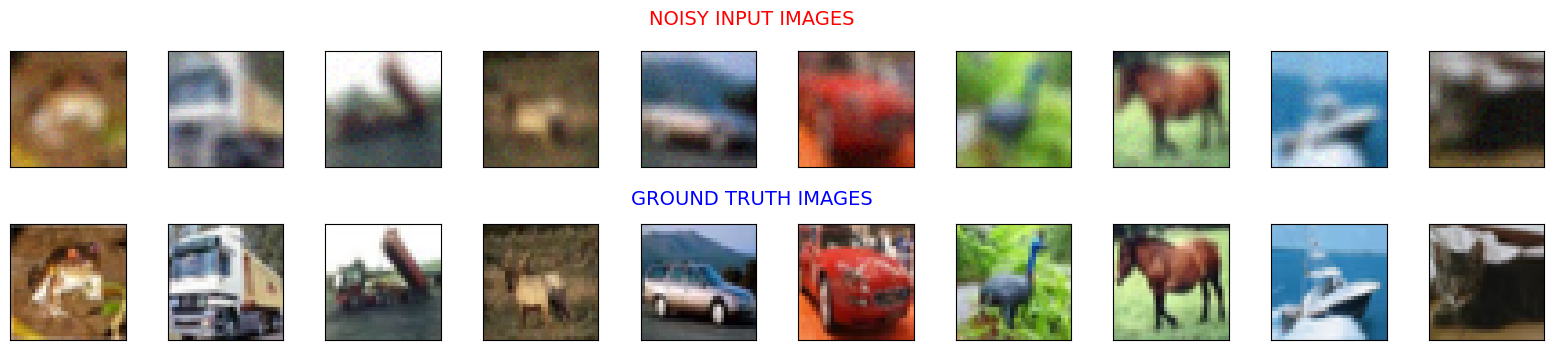

In [ ]:
train, test = getDataset()
x_train, y_train = train[0] , train[1]
x_test , y_test = test[0], test[1]
train, test = [], []
metrics_list = [PSNR,ssim, 'mae']
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
plot_imgs(x_train,y_train)
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

Sono qui implementate le funzioni precedentemente definite, quindi il dataset viene scaricato e normalizzato, successivamente suddiviso in set di training e test. Infine, vengono visualizzate le prime 10 immagini del dataset, diviso rispettivamente in 50000 e 10000 immagini di dimensioni 32 * 32 * 3 per set di allenamento e test.

Inoltre, alla riga 5 viene inizializzata una lista di metriche che verranno utilizzate nella valutazione del modello, mentre come funzione di perdita viene utilizzato l'errore quadratico medio. Più in dettaglio:


*   $MSE= \frac{\sum_{i=1}^n(Y_i - Ypred_i)^2}{n}$
*   $MAE= \frac{\sum_{i=1}^n|Y_i - Ypred_i|}{n}$
*   $PSNR= 20\cdot\log_{10}\frac{MAX(I)}{\sqrt{MSE}}$
*   $SSIM: $Si tratta di una metrica basata sulla percezione che considera il degrado dell'immagine come cambiamento percepito nelle informazioni strutturali.

Infine, nell'ultima riga ho impostato l'ottimizzatore Adam ed è lo stesso per tutte le reti. Ho scelto questo ottimizzatore perché è quello che raggiunge le migliori prestazioni in tutti i casi analizzati.










# SEQUENTIAL ENCODER - DECODER

This model has: 2435459 parameters


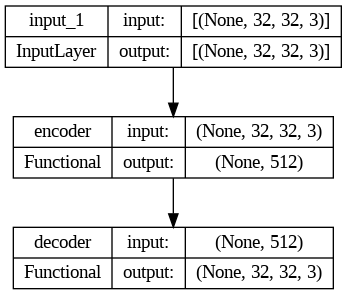

In [ ]:
def conv_block(input_layer, filter, chanDim=-1):
  # apply a CONV => RELU => BN operation
  x = Conv2D(filter, (3, 3), strides=2, padding="same")(input_layer)
  x = BatchNormalization(axis=chanDim)(x)
  x = LeakyReLU(alpha=0.2)(x)
  return x

def deconv_block(input_layer, filter, chanDim=-1):
  # apply a CONV_TRANSPOSE => RELU => BN operation
  x = Conv2DTranspose(filter, (3, 3), strides=2,padding="same")(input_layer)
  x = BatchNormalization(axis=chanDim)(x)
  x = LeakyReLU(alpha=0.2)(x)
  return x


def build_sequential_autoencoder(width, height, depth, filters=(32, 64,128), latentDim=512):

  inputShape = (height, width, depth)
  #ENCODER
  # define the input to the encoder
  inputs = Input(shape=inputShape)
  x = inputs
  # loop over the number of filters
  for f in filters:
    x = conv_block(x, f)
  #LATENT - ENCODER
  # flatten the network and to construct the latent vector
  volumeSize = K.int_shape(x)
  x = Flatten()(x)
  latent = Dense(latentDim)(x)
  # build the encoder model
  encoder = Model(inputs, latent, name="encoder")

  #DECODER
  # define the input to the decoder
  latentInputs = Input(shape=(latentDim,))
  #LATENT - DECODER
  # apply another Dense layer and reshape the image to permit convolutions
  x = Dense(np.prod(volumeSize[1:]))(latentInputs)
  x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
  # loop over our number of filters again, but this time in reverse order
  for f in filters[::-1]:
    x = deconv_block(x, f)
  # Finally we do a last deconvolution to recover the original depth of the image
  x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
  #Activation function of the model
  outputs = Activation("sigmoid")(x)

  # build the decoder model
  decoder = Model(latentInputs, outputs, name="decoder")

  # build the Autoencoder
  autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")

  return (encoder, decoder, autoencoder)

if TPU == True:
  with strategy.scope():
    (sequential_encoder, sequential_decoder, sequential_autoencoder) = build_sequential_autoencoder(32, 32, 3)
else:
  (sequential_encoder, sequential_decoder, sequential_autoencoder) = build_sequential_autoencoder(32, 32, 3)


sequential_autoencoder.compile(loss="mse", optimizer=opt, metrics=metrics_list)
print('This model has:',sequential_autoencoder.count_params(), 'parameters')
plot_model(sequential_autoencoder, to_file='sequential_autoencoder.png', show_shapes=True)

Prima di tutto, implementiamo una rete neurale di base basata su convoluzioni e deconvoluzioni per stabilire una linea di base. Si tratta di una rete sequenziale composta da 3 componenti principali:


1.   Encoder
2.   Dense layers per esprimere le caratteristiche latenti
3.   Decoder



* L'encoder accetta in input l'immagine RGB 32 x 32 e la passa a 3 blocchi convoluzionali successivi, ciascuno composto da un kernel crescente (32, 64 e 128 in questo caso). Ogni blocco convoluzionale è composto da una convoluzione con passo 2, una normalizzazione del batch e una LeakyReLU come funzione di attivazione. Si conclude questa fase con un Tensor 4 x 4 x 128.

*  A questo punto è utile comprimere le informazioni ottenute in un singolo vettore latente e per farlo appiattire la matrice ottenuta in precedenza e inserire uno strato denso con 512 neuroni. Il decoder prenderà questo tensore di 512 e applicherà un altro strato denso, questa volta con dimensione 2048, per ripristinare il numero originale di caratteristiche prima dell'operazione di appiattimento. Infine, il tensore viene rimodellato in un 4 x 4 x 128 in modo che possano essere aggiunti strati deconvoluzionali.

* Il decoder è composto da 3 blocchi deconvoluzionali, identici rispetto all'encoder, ma questa volta viene utilizzata la convoluzione trasposta invece della convoluzione standard. Dopo questo passo, l'output è un tensore 32 x 32 x 32, quindi, per avere un'immagine RGB, è necessaria un'ultima convoluzione trasposta. L'ultima funzione di attivazione è una sigmoide dato che le immagini in ingresso e in uscita sono mappate da 0 a 1.

Come ultima considerazione, ho implementato questa architettura con la funzione di attivazione LeakyReLU invece di ReLU, che consente un piccolo gradiente quando l'unità non è attiva, poiché si comporta meglio su questo modello.

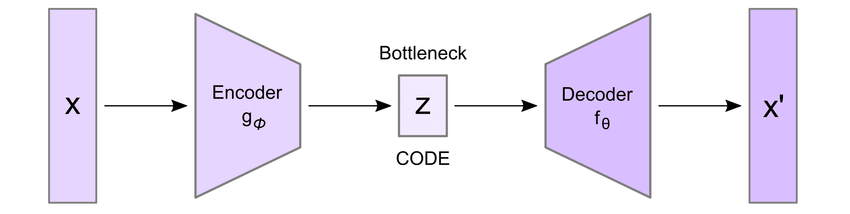

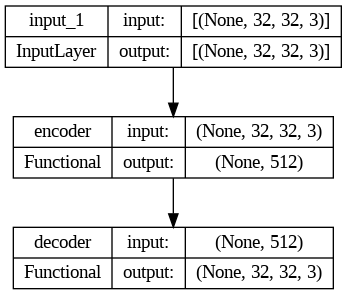

In [ ]:
plot_model(sequential_autoencoder, to_file='sequential_autoencoder.png', show_shapes=True)

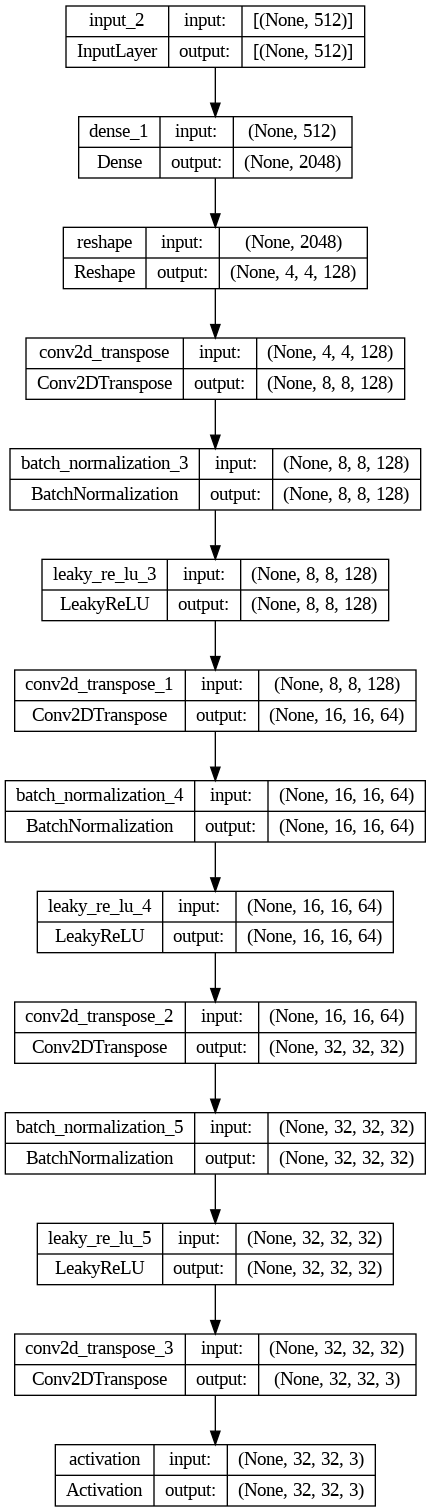

In [ ]:
plot_model(sequential_decoder, to_file='simple_decoder.png', show_shapes=True)

In [ ]:
hist_simple_autoencoder = sequential_autoencoder.fit(x_train, y_train, epochs=45, batch_size=64, validation_data=(x_test, y_test))
sequential_autoencoder.save_weights('simple_autoencoder.h5')

Epoch 1/45
782/782 [==============================] - 47s 45ms/step - loss: 0.0127 - PSNR: 19.7779 - ssim: 0.6594 - mae: 0.0838 - val_loss: 0.0080 - val_PSNR: 21.3329 - val_ssim: 0.7503 - val_mae: 0.0660
Epoch 2/45
782/782 [==============================] - 20s 26ms/step - loss: 0.0074 - PSNR: 21.7484 - ssim: 0.7669 - mae: 0.0641 - val_loss: 0.0059 - val_PSNR: 22.7531 - val_ssim: 0.7868 - val_mae: 0.0555
Epoch 3/45
782/782 [==============================] - 21s 26ms/step - loss: 0.0064 - PSNR: 22.3865 - ssim: 0.7884 - mae: 0.0596 - val_loss: 0.0057 - val_PSNR: 22.8499 - val_ssim: 0.7948 - val_mae: 0.0551
Epoch 4/45
782/782 [==============================] - 21s 27ms/step - loss: 0.0059 - PSNR: 22.7222 - ssim: 0.8002 - mae: 0.0571 - val_loss: 0.0051 - val_PSNR: 23.4220 - val_ssim: 0.8092 - val_mae: 0.0511
Epoch 5/45
782/782 [==============================] - 20s 26ms/step - loss: 0.0056 - PSNR: 22.9297 - ssim: 0.8078 - mae: 0.0554 - val_loss: 0.0052 - val_PSNR: 23.2966 - val_ssim: 0.812

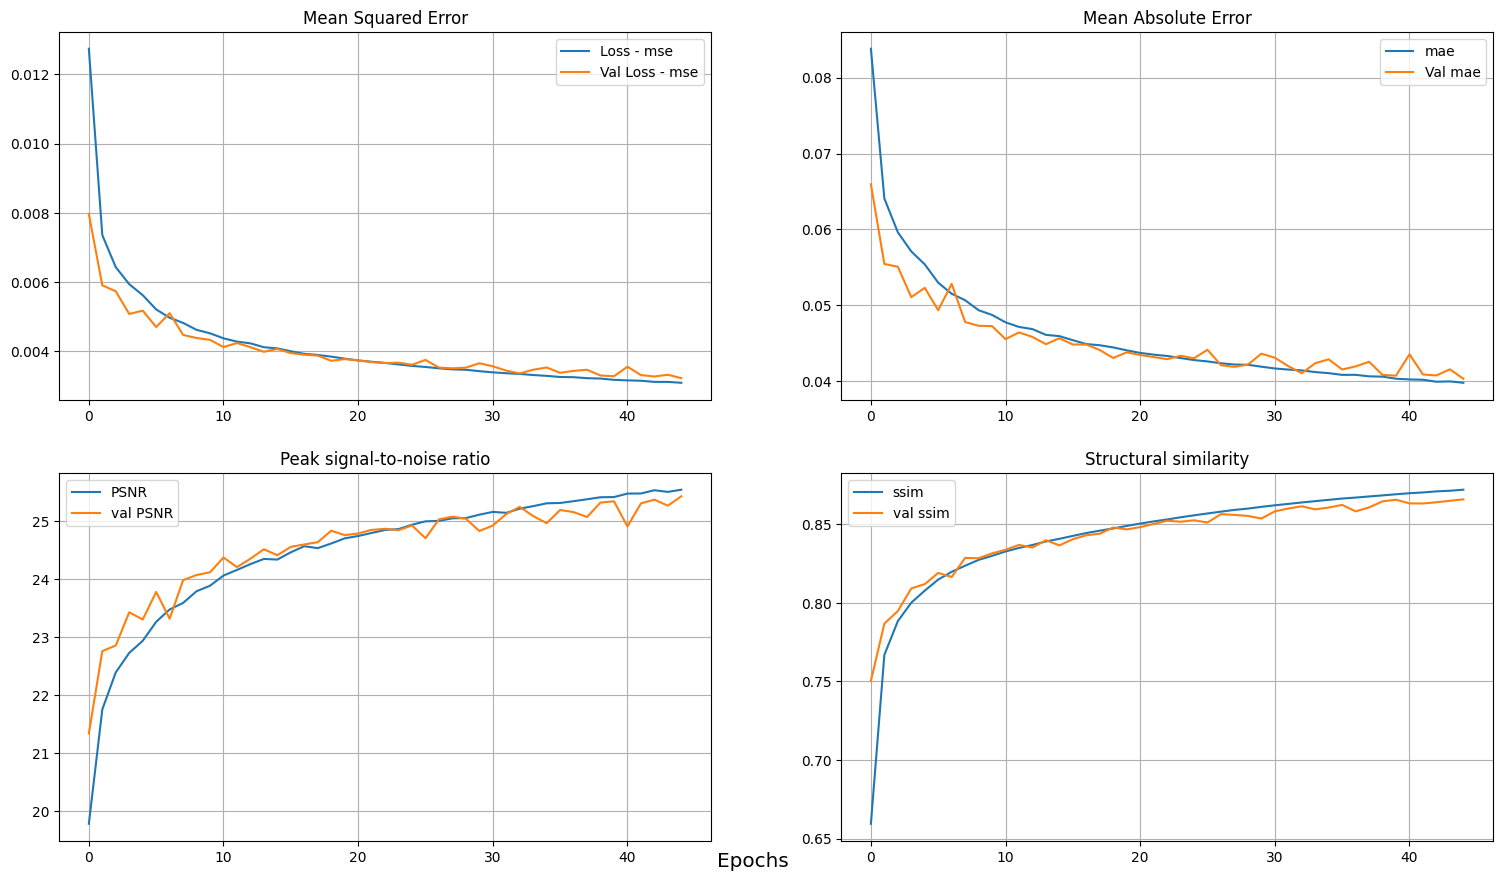

In [ ]:
plot_results(hist_simple_autoencoder)

313/313 [==============================] - 6s 14ms/step


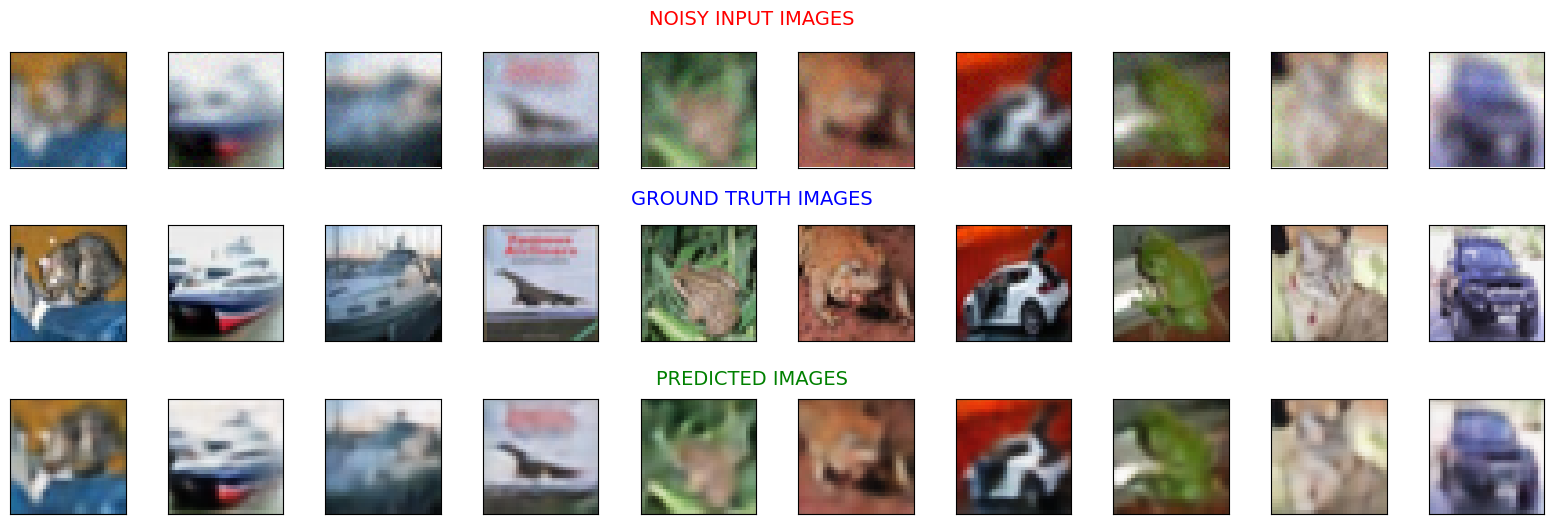

In [ ]:
y_pred_simple_auto = sequential_autoencoder.predict(x_test)
plot_imgs(x_test,y_test, y_pred_simple_auto)

Come mostrato nei grafici, questo modello raggiunge un errore quadratico medio di 0.0030 dopo 40 epoche (dopodiché inizia l'overfitting) sul set di validazione, il che, per una rete così semplice, rappresenta una buona base. Successivamente ho plottato alcuni risultati visivi per ispezionare visivamente l'output di questa rete.

# RESIDUAL ENCODER - DECODER

In [ ]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x


def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x


def build_residual_autoencoder():
   #ENCODER
   inputs = Input(shape=(32, 32, 3), name='input')
   conv_block1 = conv_block(inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)

   #DECODER
   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)
   merge4 = Concatenate()([deconv_block4, inputs])

   final_deconv = Conv2DTranspose(filters=3, kernel_size=3, padding='same')(merge4)

   outputs = Activation("sigmoid")(final_deconv)

   return ks.models.Model(inputs, outputs, name='residual_autoencoder')

Questa volta è stata implementata una rete molto simile a quella definita precedentemente, ma con un numero maggiore di blocchi convoluzionali/deconvoluzionali e, soprattutto, sono state aggiunte connessioni di salto (skip connections) dall'Encoder al Decoder per propagare i gradienti alle layer inferiori e passare dettagli dell'immagine alle layer superiori.

La rete è composta innanzitutto da un insieme di 5 blocchi convoluzionali che sono gli stessi definiti precedentemente, ognuno con uno stride di 2 (eccetto per l'ultima convoluzione che è 1) e con kernel (32, 64, 128, 256, 256). Poi c'è una fase di deconvoluzione composta da 4 blocchi deconvoluzionali con gli stessi kernel deployati prima, ma in ordine inverso (256, 128, 64, 32), ognuno dei quali è concatenato, alla fine, con l'output del blocco convoluzionale con le stesse prime due dimensioni. Infine viene applicata un'ultima deconvoluzione per ottenere un output con gli stessi canali di un'immagine RGB.

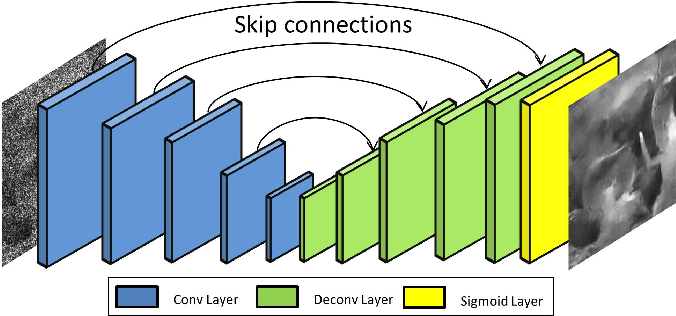

This model has: 2155220 parameters


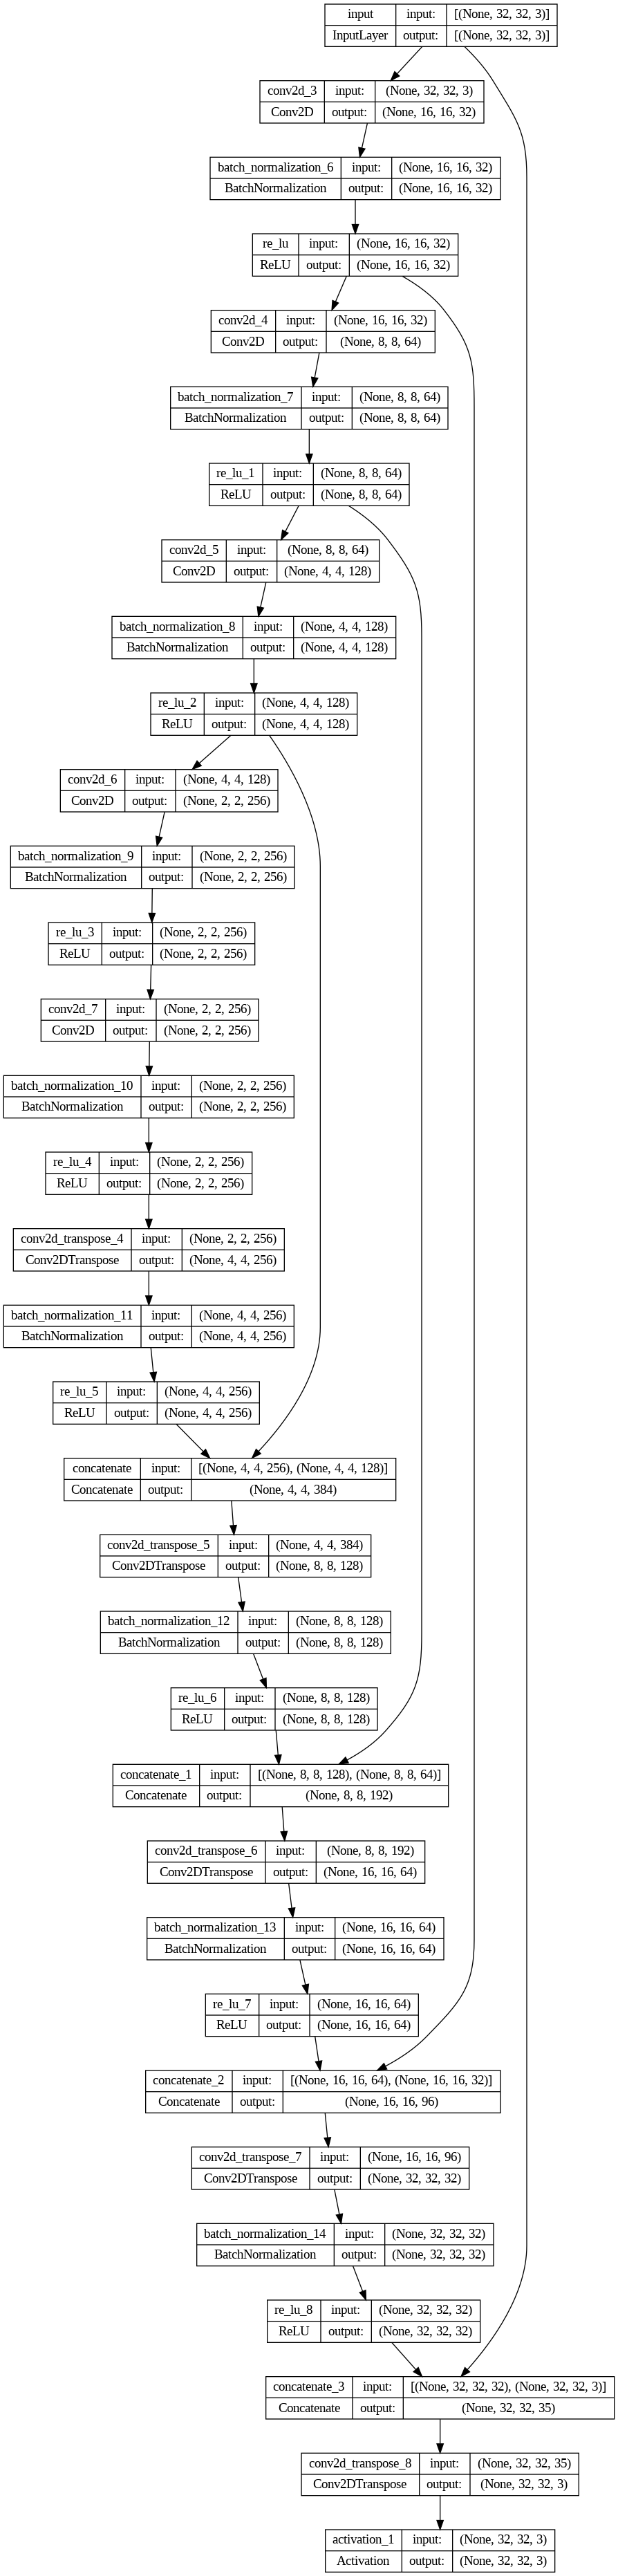

In [ ]:
if TPU == True:
  with strategy.scope():
    residual_autoencoder = build_residual_autoencoder()
else:
  residual_autoencoder = build_residual_autoencoder()
residual_autoencoder.compile(loss="mse", optimizer=opt, metrics=metrics_list)
print('This model has:',residual_autoencoder.count_params(), 'parameters')
plot_model(residual_autoencoder , to_file='residual_autoencoder.png', show_shapes=True)

In [ ]:
hist_residual_autoencoder = residual_autoencoder.fit(x_train, y_train, epochs=15, batch_size=50, validation_data=(x_test, y_test))
residual_autoencoder.save_weights('residual_autoencoder.h5')

Epoch 1/15
1000/1000 [==============================] - 48s 34ms/step - loss: 0.0058 - PSNR: 22.9719 - ssim: 0.8061 - mae: 0.0553 - val_loss: 0.0041 - val_PSNR: 24.2320 - val_ssim: 0.8351 - val_mae: 0.0466
Epoch 2/15
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0040 - PSNR: 24.3200 - ssim: 0.8427 - mae: 0.0464 - val_loss: 0.0043 - val_PSNR: 24.1117 - val_ssim: 0.8323 - val_mae: 0.0479
Epoch 3/15
1000/1000 [==============================] - 26s 26ms/step - loss: 0.0035 - PSNR: 24.8391 - ssim: 0.8566 - mae: 0.0436 - val_loss: 0.0034 - val_PSNR: 25.0931 - val_ssim: 0.8589 - val_mae: 0.0421
Epoch 4/15
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0033 - PSNR: 25.1709 - ssim: 0.8654 - mae: 0.0418 - val_loss: 0.0033 - val_PSNR: 25.2015 - val_ssim: 0.8705 - val_mae: 0.0415
Epoch 5/15
1000/1000 [==============================] - 26s 26ms/step - loss: 0.0031 - PSNR: 25.4428 - ssim: 0.8705 - mae: 0.0405 - val_loss: 0.0030 - val_PSNR: 25.5399 - val_s

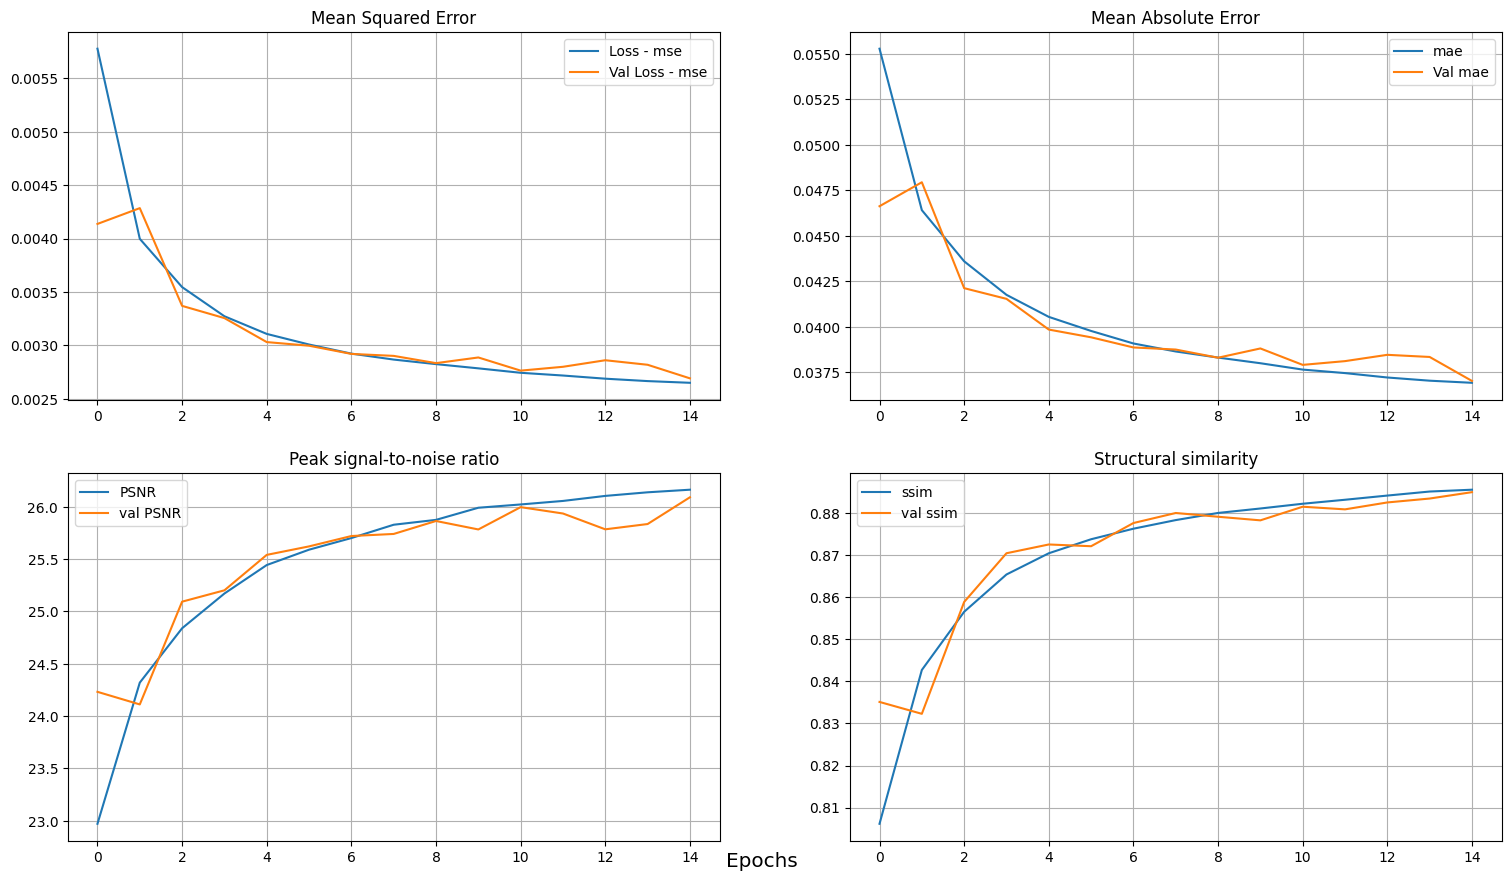

In [ ]:
plot_results(hist_residual_autoencoder)

313/313 [==============================] - 6s 15ms/step


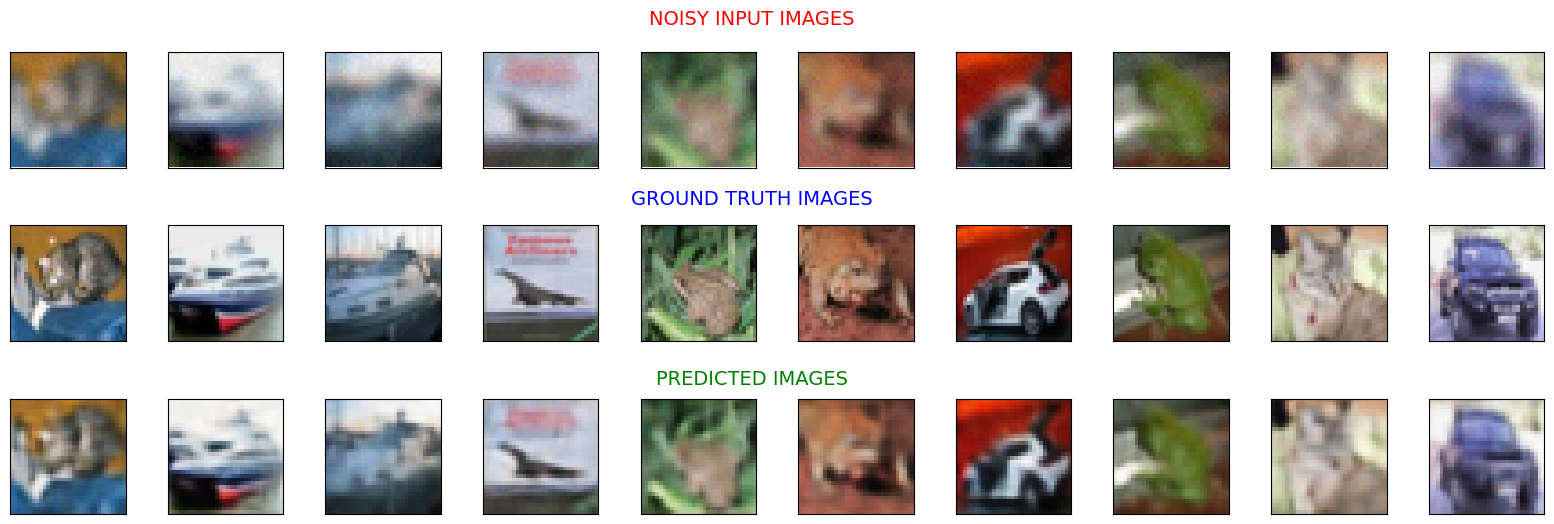

In [ ]:
y_pred_recurrent = residual_autoencoder.predict(x_test)
plot_imgs(x_test,y_test, y_pred_recurrent)

Come mostrato nei grafici, questa architettura raggiunge un errore quadratico medio di 0.0027 sulla perdita di convalida dopo 15 epoche (dopodiché inizia l'overfitting), il che è ovviamente migliore rispetto alla precedente architettura anche con qualche parametro in meno, evidenziando l'importanza delle connessioni di salto nel gestire il problema del "vanishing gradient" .  

# DEEPER RESIDUAL ENCODER - DECODER: REDNET

Ora presento la mia versione dell'architettura RedNet, ben nota per essere una delle migliori nel compito di deblurring: RedNet è un'architettura proposta da Mao et al., che consiste in un insieme di blocchi convoluzionali e deconvoluzionali.

Ogni blocco è composto da:
Convoluzione/Deconvoluzione con stride 3 e 128 canali
Normalizzazione del batch
Funzione di attivazione ReLU

Dopo 2 blocchi di convoluzione, è presente una connessione di salto al rispettivo blocco di deconvoluzione, motivo per cui nella mia implementazione i blocchi di convoluzione/deconvoluzione sono composti da 2 blocchi "standard" di convoluzione.

Ogni blocco "standard" di convoluzione/deconvoluzione viene ripetuto 15 volte per implementare l'architettura RedNet30.

L'ultima funzione di attivazione è un Sigmoid (anziché il ReLU suggerito nel paper) poiché l'output per ogni pixel deve essere compreso tra 0 e 1.

Infine, ho aggiunto un callback per ridurre il tasso di apprendimento quando il modello inizia a sovradattarsi al fine di ottenere risultati leggermente migliori.

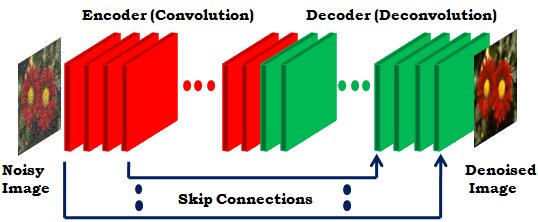

In [ ]:
def conv_block(x, filters = 128, kernel_size = (3, 3)):

  x = Conv2D(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  return x


def deconv_block(x, res,counter, filters = 128, kernel_size = (3,3)):
  x = Add()([x, res])
  x = ReLU()(x)
  x = Conv2DTranspose(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  if counter != 6:
    x = Conv2DTranspose(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
  else:
    x = Conv2DTranspose(3, kernel_size=kernel_size, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
  return x

def middle_block(x, filters = 128, kernel_size = (3, 3)):
  x = Conv2D(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2DTranspose(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  return x


def build_rednet(dimension = 30):


  residuals = []

  inputs = Input(shape=[32, 32, 3], name="InputImage")
  x = inputs

  for i in range(dimension//4):
    x = conv_block(x)
    residuals.append(x)

  x = middle_block(x)

  for i in range(dimension//4):
    x = deconv_block(x, residuals[-i], i)

  y = Add()([x, inputs])


  outputs = Activation("sigmoid")(y)

  return ks.models.Model(inputs, outputs, name='rednet')

In [ ]:
class LearningRateReducer(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    if epoch > 14:
      new_lr = old_lr * 0.8
      print("\nReducing Learning Rate from {} to {}".format(old_lr, new_lr))
      self.model.optimizer.lr.assign(new_lr)
    else:
      print("\nKeeping Learning Rate to {}".format(old_lr))

This model has: 4150540 parameters


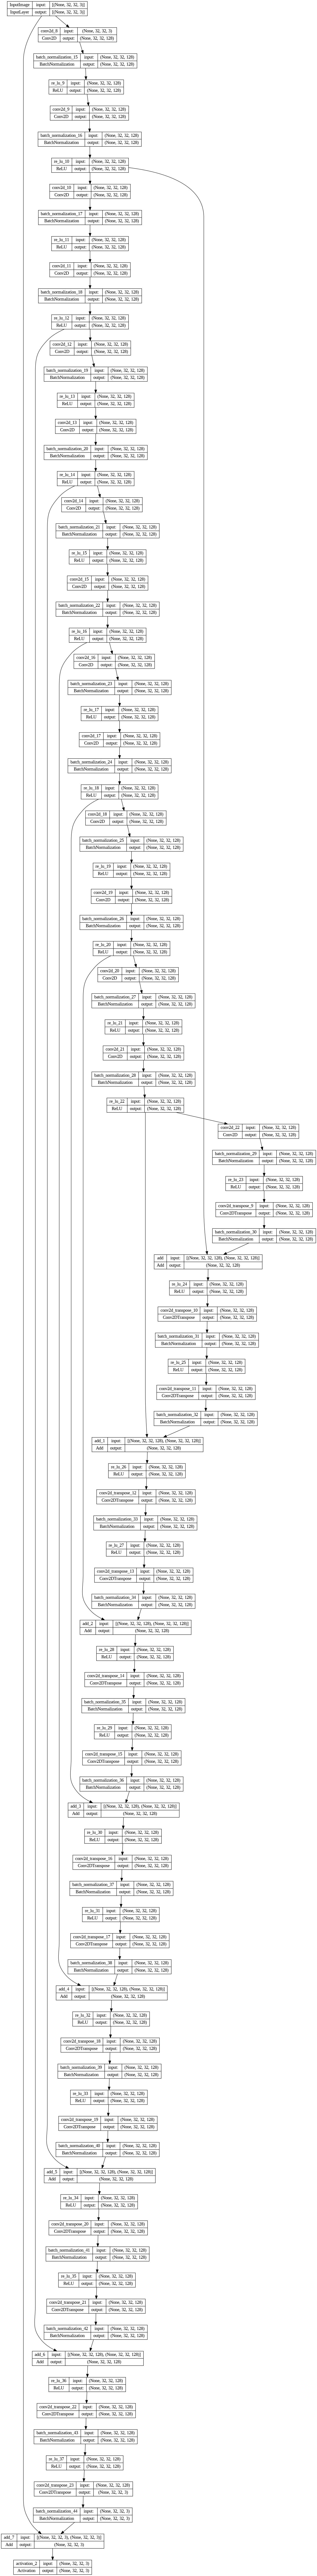

In [ ]:
if TPU == True:
  with strategy.scope():
    rednet = build_rednet()
else:
  rednet = build_rednet()
rednet.compile(loss="mse", optimizer=opt, metrics=metrics_list)
print('This model has:',rednet.count_params(), 'parameters')
plot_model(rednet, to_file='rednet.png', show_shapes=True)

In [ ]:
hist_rednet = rednet.fit(x_train, y_train, epochs=25, batch_size=64*2,
                      validation_data=(x_test, y_test), callbacks = [LearningRateReducer()])
rednet.save_weights('rednet.h5')

Epoch 1/25
  6/391 [..............................] - ETA: 20s - loss: 0.0376 - PSNR: 15.7923 - ssim: 0.5302 - mae: 0.1508

391/391 [==============================] - ETA: 0s - loss: 0.0071 - PSNR: 22.5082 - ssim: 0.8100 - mae: 0.0618
Keeping Learning Rate to 0.0010000000474974513
391/391 [==============================] - 79s 128ms/step - loss: 0.0071 - PSNR: 22.5082 - ssim: 0.8100 - mae: 0.0618 - val_loss: 0.0095 - val_PSNR: 20.5782 - val_ssim: 0.7512 - val_mae: 0.0793
Epoch 2/25
391/391 [==============================] - ETA: 0s - loss: 0.0042 - PSNR: 24.2012 - ssim: 0.8544 - mae: 0.0479
Keeping Learning Rate to 0.0010000000474974513
391/391 [==============================] - 23s 58ms/step - loss: 0.0042 - PSNR: 24.2012 - ssim: 0.8544 - mae: 0.0479 - val_loss: 0.0036 - val_PSNR: 24.7257 - val_ssim: 0.8611 - val_mae: 0.0439
Epoch 3/25
391/391 [==============================] - ETA: 0s - loss: 0.0037 - PSNR: 24.7350 - ssim: 0.8663 - mae: 0.0453
Keeping Learning Rate to 0.0010000000474974513
391/391 [==============================] - 23s 58ms/step - loss: 0.0037 - PSNR: 24.7350 - ssim: 0.8663 - mae: 0.0453 

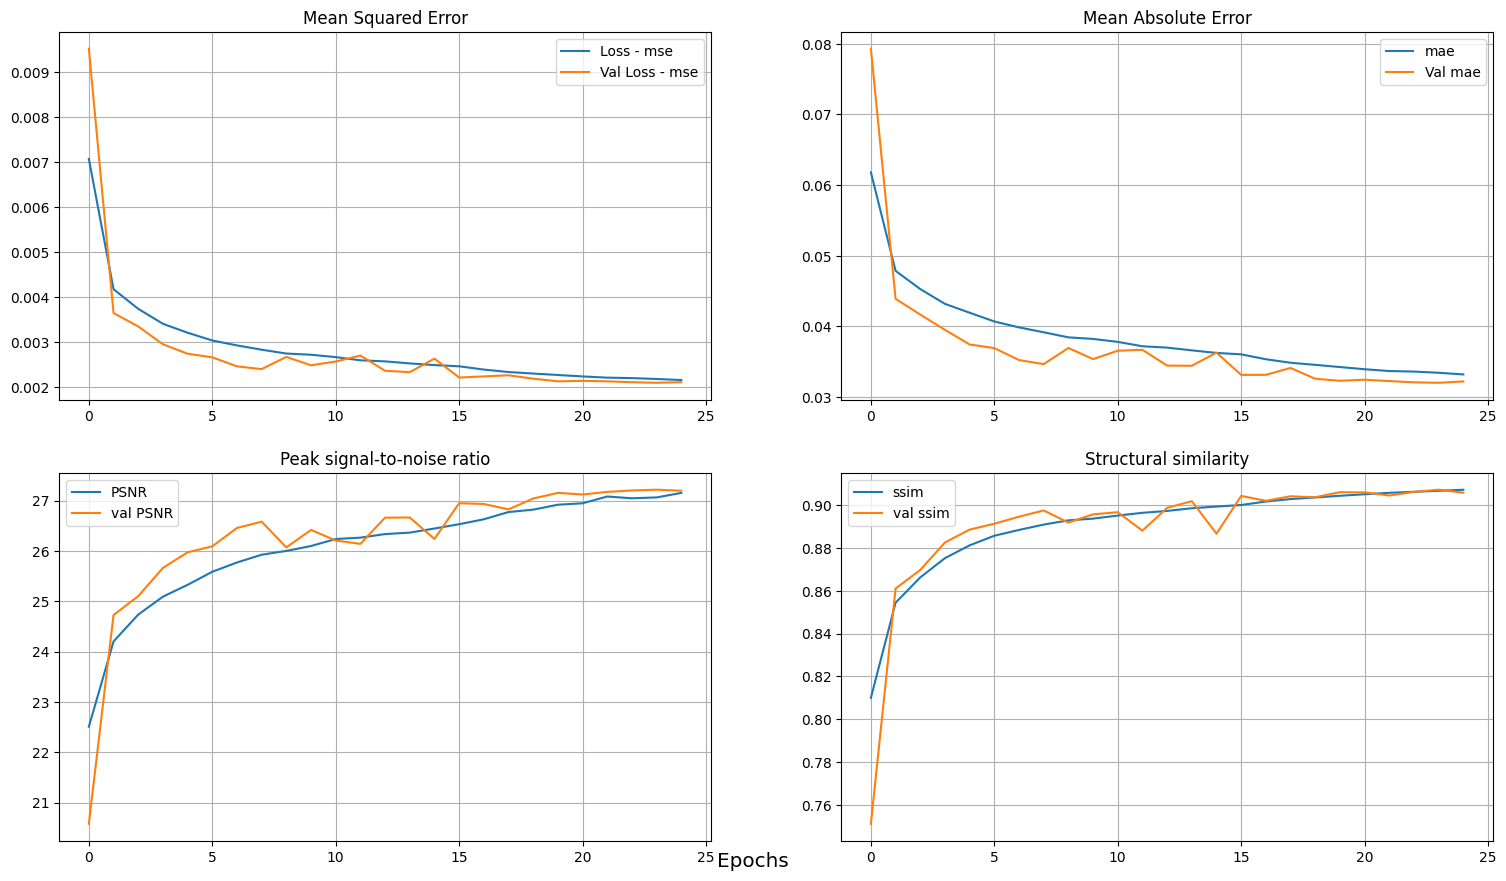

In [ ]:
plot_results(hist_rednet)

313/313 [==============================] - 12s 33ms/step


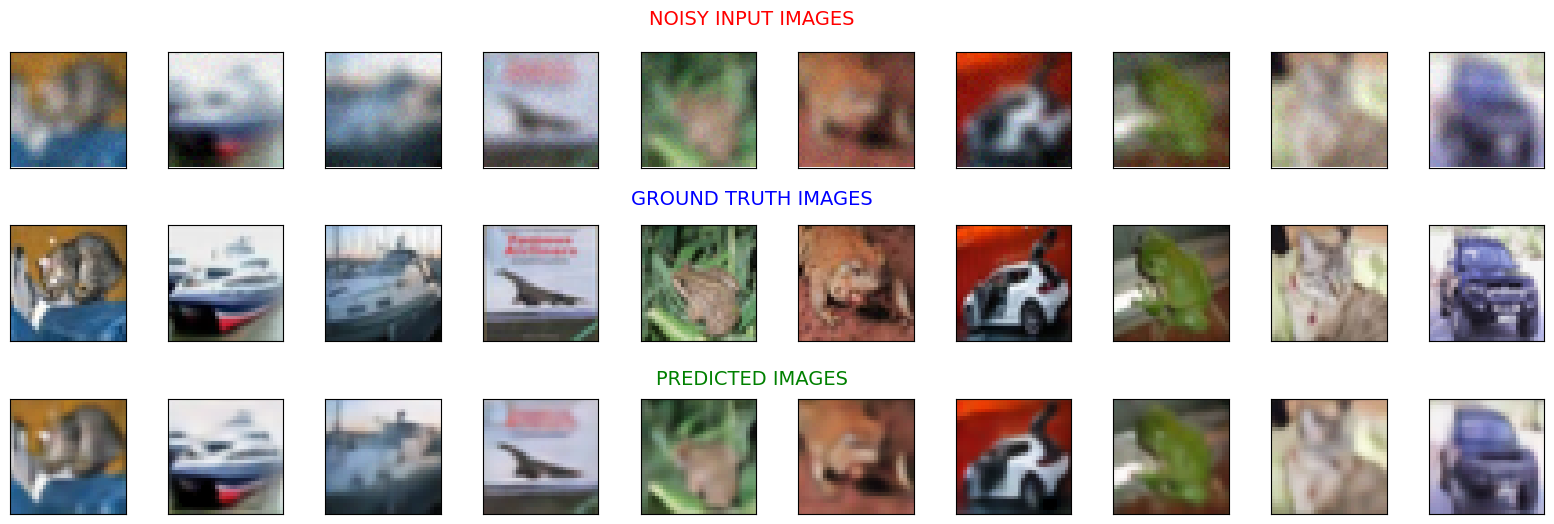

In [ ]:
y_pred_rednet = rednet.predict(x_test)
plot_imgs(x_test,y_test, y_pred_rednet)

Come si evince dai grafici questa è sicuramente l'architettura che ottiene le prestazioni migliori, ottenendo un errore quadratico medio di 0.0020 dopo 25 epoche sul set di convalida.

Naturalmente, questo è il modello più complesso tra i tre in termini di struttura e numero di parametri.